In [42]:
import matplotlib.pyplot as plt
from matplotlib.container import BarContainer
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict
from os import listdir
import json
import matplotlib

from plot_utils import *

In [43]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1.4, style="white", rc=custom_params)

In [44]:
def read_data(folder):
    # Initialize list of dataframes that we will concatenate.
    all_data = []
    
    # Get list of all JSON results files in the folder.
    files_to_read = [f for f in listdir(folder) if f.endswith(".json")]

    # Read each file into a single dataframe.
    for f in files_to_read:
        with open(folder + "/" + f, "r") as fp:
            data = json.load(fp)
        results = pd.DataFrame(data["results"])
        for k, v in data["meta"].items():
            if not isinstance(v, list):
                results[k] = v
        results["corpus"] = f.split("_")[0]
        results["model"] = f.split("_")[1]
        all_data.append(results)
    df = pd.concat(all_data)
    return df

In [45]:
# Read results for all tasks.
RESULT_DIR = f"../results/logprobs"
df = read_data(f"{RESULT_DIR}")
df.columns

Index(['item_id', 'good_sentence', 'bad_sentence', 'logprob_of_good_sentence',
       'logprob_of_bad_sentence', 'num_tokens_good_sentence',
       'num_tokens_bad_sentence', 'model', 'seed', 'eval_type', 'data_file',
       'timestamp', 'corpus', 'condition', 'context', 'sentence',
       'logprob_of_sentence', 'logprob_of_sentence_in_context',
       'num_tokens_sentence'],
      dtype='object')

In [46]:
# Exclude SocialN400 results here
df = df[df.corpus != "SocialN400"]
df = df.dropna(axis=1, how='all')
df

,item_id,good_sentence,bad_sentence,logprob_of_good_sentence,logprob_of_bad_sentence,num_tokens_good_sentence,num_tokens_bad_sentence,model,seed,eval_type,data_file,timestamp,corpus
0,1.0,The actor won the award.,The actor won the battle.,-67.945444,-71.079809,9.0,9.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:41:04,DTFit
1,2.0,The anchorman told the news.,The anchorman told the parable.,-73.403885,-82.829956,11.0,12.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:41:04,DTFit
2,3.0,The animal found the food.,The animal found the map.,-69.514266,-75.829156,9.0,9.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:41:04,DTFit
3,4.0,The ant stacked the supply.,The ant stacked the suitcase.,-89.358158,-87.600263,10.0,11.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:41:04,DTFit
4,5.0,The archeologist examined the epigraph.,The archeologist examined the dog.,-81.993661,-82.412106,13.0,11.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:41:04,DTFit
...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,510.0,The abused woman was comforted by the social w...,The social worker was comforted by the abused ...,-56.187302,-60.708265,13.0,13.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:34,EventsAdapt
510,511.0,The neuroscientist overwhelmed the lab assistant.,The lab assistant overwhelmed the neuroscientist.,-59.230340,-58.836141,11.0,11.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:34,EventsAdapt
511,512.0,The lab assistant was overwhelmed by the neuro...,The neuroscientist was overwhelmed by the lab ...,-63.497354,-62.214024,13.0,13.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:34,EventsAdapt
512,513.0,The warmonger terrorized the gunsmith.,The gunsmith terrorized the warmonger.,-65.639523,-61.812321,12.0,12.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:34,EventsAdapt


In [47]:
df['model'].unique()

array(['Mistral-7B-Instruct-v0.1', 'Mistral-7B-v0.1',
       'falcon-7b-instruct', 'falcon-7b', 'gpt2-xl', 'mpt-7b-instruct',
       'mpt-7b'], dtype=object)

In [48]:
def compute_accuracy_metric(df):
    #add new column
    df["model_prefers_good_sentence"] = \
                (df["logprob_of_good_sentence"] > df["logprob_of_bad_sentence"])
    def _success_criterion_sentence(row):
        return (row.logprob_of_good_sentence > row.logprob_of_bad_sentence)
    df["model_prefers_good_sentence"] = df.apply(_success_criterion_sentence, axis=1)
    return df

In [49]:
plot_df = compute_accuracy_metric(df)

In [50]:
plot_df

,item_id,good_sentence,bad_sentence,logprob_of_good_sentence,logprob_of_bad_sentence,num_tokens_good_sentence,num_tokens_bad_sentence,model,seed,eval_type,data_file,timestamp,corpus,model_prefers_good_sentence
0,1.0,The actor won the award.,The actor won the battle.,-67.945444,-71.079809,9.0,9.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:41:04,DTFit,True
1,2.0,The anchorman told the news.,The anchorman told the parable.,-73.403885,-82.829956,11.0,12.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:41:04,DTFit,True
2,3.0,The animal found the food.,The animal found the map.,-69.514266,-75.829156,9.0,9.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:41:04,DTFit,True
3,4.0,The ant stacked the supply.,The ant stacked the suitcase.,-89.358158,-87.600263,10.0,11.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:41:04,DTFit,False
4,5.0,The archeologist examined the epigraph.,The archeologist examined the dog.,-81.993661,-82.412106,13.0,11.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:41:04,DTFit,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,510.0,The abused woman was comforted by the social w...,The social worker was comforted by the abused ...,-56.187302,-60.708265,13.0,13.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:34,EventsAdapt,True
510,511.0,The neuroscientist overwhelmed the lab assistant.,The lab assistant overwhelmed the neuroscientist.,-59.230340,-58.836141,11.0,11.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:34,EventsAdapt,False
511,512.0,The lab assistant was overwhelmed by the neuro...,The neuroscientist was overwhelmed by the lab ...,-63.497354,-62.214024,13.0,13.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:34,EventsAdapt,False
512,513.0,The warmonger terrorized the gunsmith.,The gunsmith terrorized the warmonger.,-65.639523,-61.812321,12.0,12.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:34,EventsAdapt,False


# Load sentence information for EventsAdapt

In [51]:
import os
data_path = os.path.abspath('../datasets/single_sentences/EventsAdapt/corpus.csv')
eventsAdapt_df = pd.read_csv(data_path)
eventsAdapt_df.head()

,item_id,good_sentence,bad_sentence,good_human_score,bad_human_score,trial_type,voice
0,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active
1,2,The illness was caught by the raider.,The raider was caught by the illness.,5.333333,2.541667,AI,passive
2,3,The marauder contracted the disease.,The disease contracted the marauder.,5.680000,1.440000,AI,active
3,4,The disease was contracted by the marauder.,The marauder was contracted by the disease.,5.875000,1.818182,AI,passive
4,5,The convict dreaded the prison.,The prison dreaded the convict.,6.208333,4.318182,AI,active


In [52]:
df_scores_eventsAdapt = plot_df[plot_df.corpus == 'EventsAdapt']
df_scores_eventsAdapt.head()

,item_id,good_sentence,bad_sentence,logprob_of_good_sentence,logprob_of_bad_sentence,num_tokens_good_sentence,num_tokens_bad_sentence,model,seed,eval_type,data_file,timestamp,corpus,model_prefers_good_sentence
0,1.0,The raider caught the illness.,The illness caught the raider.,-80.383024,-83.095198,10.0,10.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:36:39,EventsAdapt,True
1,2.0,The illness was caught by the raider.,The raider was caught by the illness.,-80.226654,-79.479498,12.0,12.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:36:39,EventsAdapt,False
2,3.0,The marauder contracted the disease.,The disease contracted the marauder.,-80.572105,-82.279467,12.0,12.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:36:39,EventsAdapt,True
3,4.0,The disease was contracted by the marauder.,The marauder was contracted by the disease.,-78.742416,-87.866671,14.0,14.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:36:39,EventsAdapt,True
4,5.0,The convict dreaded the prison.,The prison dreaded the convict.,-84.144069,-83.048722,11.0,11.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:36:39,EventsAdapt,False


In [53]:
merged = eventsAdapt_df.merge(df_scores_eventsAdapt, on = ["good_sentence", "bad_sentence"])
print(len(merged))
merged.head()

3598


,item_id_x,good_sentence,bad_sentence,good_human_score,bad_human_score,trial_type,voice,item_id_y,logprob_of_good_sentence,logprob_of_bad_sentence,num_tokens_good_sentence,num_tokens_bad_sentence,model,seed,eval_type,data_file,timestamp,corpus,model_prefers_good_sentence
0,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-80.383024,-83.095198,10.0,10.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:36:39,EventsAdapt,True
1,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-85.420685,-84.774742,10.0,10.0,Mistral-7B-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:27,EventsAdapt,False
2,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-50.871655,-45.857755,7.0,7.0,falcon-7b-instruct,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:29,EventsAdapt,False
3,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-45.142372,-45.505023,7.0,7.0,falcon-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:00,EventsAdapt,True
4,1,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-55.528430,-61.421805,9.0,9.0,gpt2-xl,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:11:43,EventsAdapt,True


# ALL DATASETS ANALYSIS

In [54]:
# full merged
plot_df_without_eA = plot_df.loc[plot_df["corpus"] != "EventsAdapt"]
full_df = pd.concat([merged, plot_df_without_eA])

# Check if "trial_type" is not NaN
not_nan_mask = ~full_df["trial_type"].isna()
# Concatenate "corpus" and "trial_type" columns for non-NaN rows
full_df.loc[not_nan_mask, "corpus"] = full_df.loc[not_nan_mask, "corpus"] + "_" + full_df.loc[not_nan_mask, "trial_type"]
full_df

,item_id_x,good_sentence,bad_sentence,good_human_score,bad_human_score,trial_type,voice,item_id_y,logprob_of_good_sentence,logprob_of_bad_sentence,num_tokens_good_sentence,num_tokens_bad_sentence,model,seed,eval_type,data_file,timestamp,corpus,model_prefers_good_sentence,item_id
0,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-80.383024,-83.095198,10.0,10.0,Mistral-7B-Instruct-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:36:39,EventsAdapt_AI,True,NaN
1,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-85.420685,-84.774742,10.0,10.0,Mistral-7B-v0.1,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:27,EventsAdapt_AI,False,NaN
2,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-50.871655,-45.857755,7.0,7.0,falcon-7b-instruct,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:29,EventsAdapt_AI,False,NaN
3,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-45.142372,-45.505023,7.0,7.0,falcon-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:00,EventsAdapt_AI,True,NaN
4,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-55.528430,-61.421805,9.0,9.0,gpt2-xl,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:11:43,EventsAdapt_AI,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,NaN,The witness explained the circumstances.,The witness explained the equation.,NaN,NaN,NaN,NaN,NaN,-47.927296,-52.628216,8.0,8.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:42:07,DTFit,True,393.0
391,NaN,The witness reported the crime.,The witness reported the birth.,NaN,NaN,NaN,NaN,NaN,-45.469055,-50.986553,8.0,8.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:42:07,DTFit,True,394.0
392,NaN,The woman carried the bag.,The woman carried the stone.,NaN,NaN,NaN,NaN,NaN,-42.243927,-43.401520,8.0,8.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:42:07,DTFit,True,395.0
393,NaN,The woman opened the bag.,The woman opened the manhole.,NaN,NaN,NaN,NaN,NaN,-41.818043,-47.188039,8.0,9.0,mpt-7b,1,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-03 00:42:07,DTFit,True,396.0


# Add remaining human data and prep dataframe

In [55]:
human_frames = []
for d in ["DTFit", "EventsAdapt"]:
    human_data_path = os.path.abspath(f'../datasets/single_sentences/{d}/corpus.csv')
    human_df = pd.read_csv(human_data_path)
    human_df["corpus"] = d
    human_df["model"] = "human"
    if d == "EventsAdapt":
        human_df["corpus"] = human_df["corpus"] + "_" + human_df["trial_type"]
    human_frames.append(human_df)
human_df_full = pd.concat(human_frames)
human_df_full["model_prefers_good_sentence"] = \
                (human_df_full["good_human_score"] > human_df_full["bad_human_score"])
del human_df_full["good_human_score"]
del human_df_full["bad_human_score"]
human_df_full

,item_id,good_sentence,bad_sentence,corpus,model,trial_type,voice,model_prefers_good_sentence
0,1,The actor won the award.,The actor won the battle.,DTFit,human,NaN,NaN,True
1,2,The anchorman told the news.,The anchorman told the parable.,DTFit,human,NaN,NaN,True
2,3,The animal found the food.,The animal found the map.,DTFit,human,NaN,NaN,True
3,4,The ant stacked the supply.,The ant stacked the suitcase.,DTFit,human,NaN,NaN,True
4,5,The archeologist examined the epigraph.,The archeologist examined the dog.,DTFit,human,NaN,NaN,True
...,...,...,...,...,...,...,...,...
509,510,The abused woman was comforted by the social w...,The social worker was comforted by the abused ...,EventsAdapt_AAN,human,AAN,passive,True
510,511,The neuroscientist overwhelmed the lab assistant.,The lab assistant overwhelmed the neuroscientist.,EventsAdapt_AAN,human,AAN,active,True
511,512,The lab assistant was overwhelmed by the neuro...,The neuroscientist was overwhelmed by the lab ...,EventsAdapt_AAN,human,AAN,passive,True
512,513,The warmonger terrorized the gunsmith.,The gunsmith terrorized the warmonger.,EventsAdapt_AAN,human,AAN,active,True


In [56]:
combined_df = pd.concat([full_df, human_df_full])
combined_df.head()

,item_id_x,good_sentence,bad_sentence,good_human_score,bad_human_score,trial_type,voice,item_id_y,logprob_of_good_sentence,logprob_of_bad_sentence,num_tokens_good_sentence,num_tokens_bad_sentence,model,seed,eval_type,data_file,timestamp,corpus,model_prefers_good_sentence,item_id
0,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-80.383024,-83.095198,10.0,10.0,Mistral-7B-Instruct-v0.1,1.0,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:36:39,EventsAdapt_AI,True,NaN
1,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-85.420685,-84.774742,10.0,10.0,Mistral-7B-v0.1,1.0,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:27,EventsAdapt_AI,False,NaN
2,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-50.871655,-45.857755,7.0,7.0,falcon-7b-instruct,1.0,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:29,EventsAdapt_AI,False,NaN
3,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-45.142372,-45.505023,7.0,7.0,falcon-7b,1.0,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:00,EventsAdapt_AI,True,NaN
4,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-55.528430,-61.421805,9.0,9.0,gpt2-xl,1.0,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:11:43,EventsAdapt_AI,True,NaN


In [57]:
# Convert the "corpus" column to a Categorical data type with desired order
combined_df['corpus'] = pd.Categorical(combined_df['corpus'],
                                       categories=["EventsAdapt_AI", "DTFit", "EventsAdapt_AAN"], ordered=True)
combined_df

,item_id_x,good_sentence,bad_sentence,good_human_score,bad_human_score,trial_type,voice,item_id_y,logprob_of_good_sentence,logprob_of_bad_sentence,num_tokens_good_sentence,num_tokens_bad_sentence,model,seed,eval_type,data_file,timestamp,corpus,model_prefers_good_sentence,item_id
0,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-80.383024,-83.095198,10.0,10.0,Mistral-7B-Instruct-v0.1,1.0,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:36:39,EventsAdapt_AI,True,NaN
1,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-85.420685,-84.774742,10.0,10.0,Mistral-7B-v0.1,1.0,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:27,EventsAdapt_AI,False,NaN
2,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-50.871655,-45.857755,7.0,7.0,falcon-7b-instruct,1.0,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:12:29,EventsAdapt_AI,False,NaN
3,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-45.142372,-45.505023,7.0,7.0,falcon-7b,1.0,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:13:00,EventsAdapt_AI,True,NaN
4,1.0,The raider caught the illness.,The illness caught the raider.,5.545455,3.083333,AI,active,1.0,-55.528430,-61.421805,9.0,9.0,gpt2-xl,1.0,direct,/net/vast-storage.ib.cluster/scratch/vast/evla...,2024-02-11 20:11:43,EventsAdapt_AI,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,NaN,The abused woman was comforted by the social w...,The social worker was comforted by the abused ...,NaN,NaN,AAN,passive,NaN,NaN,NaN,NaN,NaN,human,NaN,NaN,NaN,NaN,EventsAdapt_AAN,True,510.0
510,NaN,The neuroscientist overwhelmed the lab assistant.,The lab assistant overwhelmed the neuroscientist.,NaN,NaN,AAN,active,NaN,NaN,NaN,NaN,NaN,human,NaN,NaN,NaN,NaN,EventsAdapt_AAN,True,511.0
511,NaN,The lab assistant was overwhelmed by the neuro...,The neuroscientist was overwhelmed by the lab ...,NaN,NaN,AAN,passive,NaN,NaN,NaN,NaN,NaN,human,NaN,NaN,NaN,NaN,EventsAdapt_AAN,True,512.0
512,NaN,The warmonger terrorized the gunsmith.,The gunsmith terrorized the warmonger.,NaN,NaN,AAN,active,NaN,NaN,NaN,NaN,NaN,human,NaN,NaN,NaN,NaN,EventsAdapt_AAN,True,513.0


In [19]:
print_df = combined_df[["corpus", "model", "model_prefers_good_sentence"]]

result_df = print_df.groupby(["corpus", "model"]).agg(['mean', 'sem']).reset_index()

result_df.to_csv("result_df.csv", index=False)
result_df

corpus                     model model_prefers_good_sentence  \
                                                                     mean   
0    EventsAdapt_AI  Mistral-7B-Instruct-v0.1                    0.929688   
1    EventsAdapt_AI           Mistral-7B-v0.1                    0.949219   
2    EventsAdapt_AI                 falcon-7b                    0.968750   
3    EventsAdapt_AI        falcon-7b-instruct                    0.937500   
4    EventsAdapt_AI                   gpt2-xl                    0.945312   
5    EventsAdapt_AI                     human                    0.992188   
6    EventsAdapt_AI                    mpt-7b                    0.933594   
7    EventsAdapt_AI           mpt-7b-instruct                    0.925781   
8             DTFit  Mistral-7B-Instruct-v0.1                    0.934177   
9             DTFit           Mistral-7B-v0.1                    0.906329   
10            DTFit                 falcon-7b                    0.918987   
11            DTFit        falcon-7b-instruct                    0.913924   
12            DTFit                   gpt2-xl                    0.875949   
13            DTFit                     human                    0.989873   
14            DTFit                    mpt-7b                    0.934177   
15            DTFit           mpt-7b-instruct                    0.926582   
16  EventsAdapt_AAN  Mistral-7B-Instruct-v0.1                    0.728682   
17  EventsAdapt_AAN           Mistral-7B-v0.1                    0.817829   
18  EventsAdapt_AAN                 falcon-7b                    0.794574   
19  EventsAdapt_AAN        falcon-7b-instruct                    0.736434   
20  EventsAdapt_AAN                   gpt2-xl                    0.724806   
21  EventsAdapt_AAN                     human                    0.957364   
22  EventsAdapt_AAN                    mpt-7b                    0.705426   
23  EventsAdapt_AAN           mpt-7b-instruct                    0.713178   

              
         sem  
0   0.016011  
1   0.013749  
2   0.010896  
3   0.015158  
4   0.014238  
5   0.005513  
6   0.015592  
7   0.016415  
8   0.012493  
9   0.014679  
10  0.013746  
11  0.014130  
12  0.016607  
13  0.005044  
14  0.012493  
15  0.013140  
16  0.027736  
17  0.024077  
18  0.025202  
19  0.027482  
20  0.027859  
21  0.012603  
22  0.028435  
23  0.028212

In [20]:
combined_df.corpus.unique()

['EventsAdapt_AI', 'EventsAdapt_AAN', 'DTFit']
Categories (3, object): ['EventsAdapt_AI' < 'DTFit' < 'EventsAdapt_AAN']

# Stats

In [21]:
import scipy.stats
import statsmodels.stats.multitest
from statistics import mean, stdev
from math import sqrt

def cohens_d(v1, v2):
    return (mean(v1) - mean(v2)) / (sqrt((stdev(v1) ** 2 + stdev(v2) ** 2) / 2))

def assign_significance_labels(pvals):
    return ["***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "n.s." for p in pvals]

def get_stats_df(df, corpus):
    df_copy = df.copy()
    df_copy = df_copy[df_copy['corpus'] == corpus]
    df_copy["Accuracy"] = df_copy["model_prefers_good_sentence"].apply(lambda x: 1 if x else 0)

    human_scores = df_copy[df_copy['model'] == 'human']["Accuracy"].tolist()
    gpt_scores = df_copy[df_copy['model'] == 'gpt2-xl']["Accuracy"].tolist()

    results = []

    for model in PRETTYNAMES.keys():
        if model in ["human", "gpt2-xl"]:
            continue

        m_scores = df_copy[df_copy['model'] == model]["Accuracy"].tolist()

        if m_scores:
            ttest2human, pval2human = scipy.stats.ttest_rel(m_scores, human_scores)
            ttest2gpt, pval2gpt = scipy.stats.ttest_rel(m_scores, gpt_scores)

            cohensd2human = cohens_d(human_scores, m_scores)
            cohensd2gpt = cohens_d(gpt_scores, m_scores)

            results.append({
                "model": PRETTYNAMES[model],
                "ttest2human": ttest2human,
                "ttest2gpt": ttest2gpt,
                "pval2human": pval2human,
                "pval2gpt": pval2gpt,
                "cohensd2human": cohensd2human,
                "cohensd2gpt": cohensd2gpt
            })

    stats_df = pd.DataFrame(results)

    # Correct for multiple comparisons within each corpus
    stats_df['adjusted_pvals2human'] = statsmodels.stats.multitest.multipletests(stats_df['pval2human'], method='bonferroni')[1]
    stats_df['adjusted_pvals2gpt'] = statsmodels.stats.multitest.multipletests(stats_df['pval2gpt'], method='bonferroni')[1]

    # Assign significance levels
    stats_df['significance2human'] = assign_significance_labels(stats_df['adjusted_pvals2human'])
    stats_df['significance2gpt'] = assign_significance_labels(stats_df['adjusted_pvals2gpt'])

    # round
    for col in stats_df.columns:
        if col not in ['model', 'significance2human', 'significance2gpt']:
            stats_df[col] = stats_df[col].round(3)

    return stats_df


In [22]:
for corpus in ['EventsAdapt_AI', 'EventsAdapt_AAN', 'DTFit']:
    print(corpus)
    stats_df = get_stats_df(combined_df, corpus)
    stats_df.to_csv(f"figures/logprobs_stats_{corpus}.csv", index=False)
    print(stats_df)

EventsAdapt_AI
              model  ttest2human  ttest2gpt  pval2human  pval2gpt  \
0    Mistral (base)       -3.102      0.242       0.002     0.809   
1  Mistral (instr.)       -4.123     -0.852       0.000     0.395   
2     Falcon (base)       -2.136      1.739       0.034     0.083   
3   Falcon (instr.)       -3.580     -0.426       0.000     0.671   
4        MPT (base)       -3.729     -0.625       0.000     0.533   
5      MPT (instr.)       -4.014     -0.928       0.000     0.354   

   cohensd2human  cohensd2gpt  adjusted_pvals2human  adjusted_pvals2gpt  \
0          0.256       -0.017                 0.013                 1.0   
1          0.326        0.064                 0.000                 1.0   
2          0.170       -0.116                 0.202                 0.5   
3          0.300        0.033                 0.002                 1.0   
4          0.313        0.049                 0.001                 1.0   
5          0.339        0.079                 0.000

# Plot lineplot for AAN

/tmp/ipykernel_3200680/3935688990.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aan_df['version'] = aan_df.apply(assign_version, axis=1)
/tmp/ipykernel_3200680/3935688990.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aan_df['model_class'] = aan_df.apply(assign_model_class, axis=1)
/tmp/ipykernel_3200680/3935688990.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

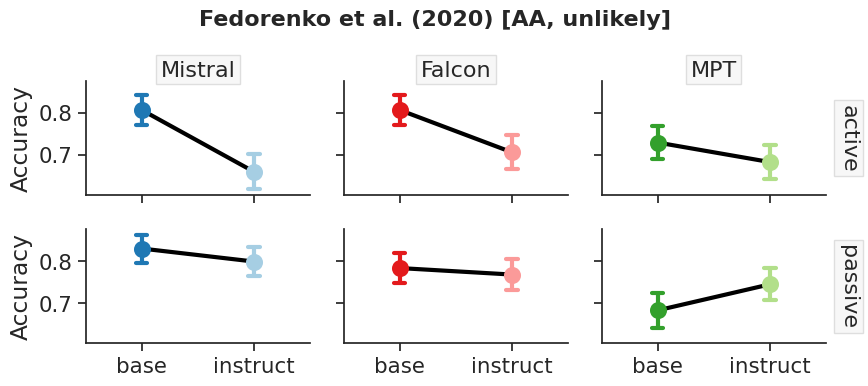

In [23]:
aan_df = combined_df.loc[combined_df["corpus"] == "EventsAdapt_AAN"]

# Update the 'model' column to include 'base' or 'instruct' in the model name
def assign_version(row):
    return "instruct" if "nstruct" in row["model"] else "base"

# Add model class
def assign_model_class(row):
    return row["model"].split("-")[0]

aan_df['version'] = aan_df.apply(assign_version, axis=1)
aan_df['model_class'] = aan_df.apply(assign_model_class, axis=1)

# Ensure 'model' is treated as a categorical type
aan_df['model'] = aan_df['model'].astype('category')
aan_df['version'] = pd.Categorical(aan_df['version'],categories=["base", "instruct"], ordered=True)

# exclude humans
aan_df_noHumans = aan_df.loc[aan_df["model"] != "human"]

# exclude baselines
aan_df_noHumans = aan_df_noHumans.loc[aan_df_noHumans["model"] != "gpt2-xl"]

# Custom plotting function
def custom_pointplot(data, **kwargs):
    # Directly use the data passed to the function
    sns.pointplot(x='version', y='model_prefers_good_sentence', hue='model',
                  data=data, palette=MODEL_PAL, errorbar='se', 
                  capsize=0.1, markersize=10, linewidth=3, legend=False)

# Custom plotting function for lines
def custom_lineplot(data, **kwargs):
    sns.lineplot(x='version', y='model_prefers_good_sentence', 
                 data=data, color='black', lw=3, errorbar=None)

# Initialize a grid of plots with an Axes for each voice condition
g = sns.FacetGrid(aan_df_noHumans, row="voice", col="model_class", height=2, aspect=1.5, sharey=True)

# Draw the custom lineplot onto each Axes in the grid
g = g.map_dataframe(custom_lineplot)

# Then overlay the pointplot
g = g.map_dataframe(custom_pointplot)

# Customize the axes and titles
# Define the properties of the bounding box
bbox_props = dict(boxstyle="square,pad=0.2", ec="lightgray", lw=1, facecolor="whitesmoke", alpha=0.7)


g.set_titles("")
g.set_axis_labels("", "Accuracy")

# Add the rotated text annotations
for ax, col_name in zip(g.axes[0, :], ["Mistral", "Falcon", "MPT"]):
    ax.text(0.5, 1.1, col_name, rotation=0, transform=ax.transAxes, 
            ha="center", va="center", fontsize=16, fontweight="normal", bbox=bbox_props)

# Add the rotated text annotations
for ax, row_name in zip(g.axes[:, -1], aan_df_noHumans['voice'].unique()):
    ax.text(1.1, 0.5, row_name, rotation=270, transform=ax.transAxes, 
            ha="center", va="center", fontsize=16, fontweight="normal", bbox=bbox_props)

g.figure.suptitle("Fedorenko et al. (2020) [AA, unlikely]", fontweight='bold', fontsize=16)
# Show the final plot with a tight layout
g.tight_layout()


# Adjust further if any labels are still overlapping
plt.subplots_adjust(top=0.8)

plt.savefig('figures/DifferencePlot.ActiveVsPassive.Faceted.png', dpi=280, bbox_inches="tight")

plt.show()